In [1]:
import io
import requests
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, Dinov2Model

device = "cuda" if torch.cuda.is_available() else "cpu"

img = Image.open("//home/mak/PycharmProjects/SegEdge/notebooks/Upscaler/Random1.png").convert("RGB")


In [2]:
from transformers import AutoModel

# 2) DINOv3 ViT-L/16 features (tokens at 32x32 for 500 with patch 16)
processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vitl16-pretrain-sat493m")
model = AutoModel.from_pretrained("facebook/dinov3-vitl16-pretrain-sat493m", token=True).to(device).eval()



In [3]:

img_size = 600

inputs = processor(
    images=img,
    do_resize=True,
    size={"shortest_edge": img_size},
    do_center_crop=True,
    crop_size={"height": img_size, "width": img_size},
    return_tensors="pt",
)
hr_image = inputs["pixel_values"].to(device)  #

with torch.no_grad():
    out = model(pixel_values=hr_image)
    tokens = out.last_hidden_state[:, 1:, :]  # drop [CLS]

B, N, C = tokens.shape
h = w = int(N ** 0.5)
if not  h * w == N:


    print (f"Non-square token grid (N={N})")
    print("Original tokens shape:", tokens.shape)

    #cut to square
    new_N = h * h
    tokens = tokens[:, :new_N, :]
    print("Cut tokens to:", tokens.shape)


lr_features = tokens.reshape(B, h, w, C).permute(0, 3, 1, 2).contiguous()  # (1, C, 32, 32)


Non-square token grid (N=1373)
Original tokens shape: torch.Size([1, 1373, 1024])
Cut tokens to: torch.Size([1, 1369, 1024])


In [ ]:
import torch
from torchvision import transforms
import numpy as np

# ViT patch size and current image size
ps = 16
W, H = img.size

# compute next multiples so patches tile cleanly
Wm = ((W + ps - 1) // ps) * ps
Hm = ((H + ps - 1) // ps) * ps
pad_w, pad_h = Wm - W, Hm - H

print(f"original: {W}x{H}  →  next multiples of {ps}: {Wm}x{Hm}  (add {pad_w} px width, {pad_h} px height)")

# padding: (left, top, right, bottom)
pad_to_multiple = transforms.Pad((0, 0, pad_w, pad_h), fill=0)
to_tensor = transforms.Compose([pad_to_multiple, transforms.ToTensor()])

# convert to tensor
img_tensor = to_tensor(img)
print("tensor shape:", tuple(img_tensor.shape))

# normalize using DINOv3 processor stats
normalize = transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
img_norm = normalize(img_tensor)

# add batch dim and move to device (this is hr_image for AnyUp)
hr_image = img_norm.unsqueeze(0).to(device)
print("hr_image for upsampler:", tuple(hr_image.shape), " device:", hr_image.device)

# forward pass to get patch tokens
with torch.no_grad():
    out = model(pixel_values=hr_image)

# drop CLS and register tokens
R = getattr(model.config, "num_register_tokens", 0)
patch = out.last_hidden_state[:, 1 + R :, :]
print("patch shape (1,P,D):", tuple(patch.shape))

# compute patch grid dims
ps, Hx, Wx = 16, hr_image.shape[2], hr_image.shape[3]
Hp, Wp = Hx // ps, Wx // ps

# reshape to spatial grid (B, Hp, Wp, D) then to (B, D, Hp, Wp) for upsampler
patch_grid = patch.reshape(1, Hp, Wp, patch.shape[-1])
lr_features = patch_grid.permute(0, 3, 1, 2).contiguous()  # (1, D, Hp, Wp)

print(f"lr_features shape: {tuple(lr_features.shape)}")

# now feed hr_image and lr_features to the upsampler
upsampler = torch.hub.load("wimmerth/anyup", "anyup", verbose=False).cpu().eval()
hr_image_cpu = hr_image.cpu()
lr_features_cpu = lr_features.cpu()
with torch.no_grad():
    hr_features = upsampler(hr_image_cpu, lr_features_cpu, q_chunk_size=64)

print("hr_features shape:", tuple(hr_features.shape))


original: 2190x1125  →  next multiples of 16: 2192x1136  (add 2 px width, 11 px height)
tensor shape: (3, 1136, 2192)
hr_image for upsampler: (1, 3, 1136, 2192)  device: cuda:0
patch shape (1,P,D): (1, 9727, 1024)
lr_features shape: (1, 1024, 71, 137)


In [5]:
print(hr_features.shape)

B, C, H, W = hr_features.shape
X = hr_features.permute(0, 2, 3, 1).reshape(B, -1, C)   # (90000, 1024)

print("X shape: ",X.shape)

torch.Size([1, 1024, 600, 600])
X shape:  torch.Size([1, 360000, 1024])


In [6]:
# we’ll cluster in feature space, so build a 2D matrix X = (num_patches × feature_dim)
import numpy as np

# L2-normalize each patch vector so distance ~ cosine distance (helps k-means separate textures like roads/roofs)
X = X[0].detach().cpu().numpy().astype("float32")
X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)

# print sanity checks before clustering
print("X shape:", X.shape, " mean L2 norm:", float(np.linalg.norm(X, axis=1).mean()))


X shape: (360000, 1024)  mean L2 norm: 1.0


In [7]:
from sklearn.cluster import KMeans
# we’ll use MiniBatchKMeans to group similar patch embeddings (fast, memory-friendly) into k semantic clusters
from sklearn.cluster import MiniBatchKMeans

# choose an initial cluster count (k=8 is a reasonable start to separate roads/roofs/veg/shadows etc.)
kmeans = MiniBatchKMeans(n_clusters=8, random_state=12, batch_size=2048, max_iter=100)

# run clustering on the L2-normalized embeddings to obtain one label per patch (0..k-1)
labels = kmeans.fit_predict(X)

# report how many patches fell into each cluster so we can gauge balance before mapping to the image grid
print("labels shape:", labels.shape, " | counts per cluster:", np.bincount(labels, minlength=8))


labels shape: (360000,)  | counts per cluster: [46191 61568 59645 51889 35853 20589 36199 48066]


In [8]:

# derive patches per side and confirm P = Hp*Wp matches 90000
ps = 16
Hp, Wp = H // ps, W // ps

label_grid = labels.reshape(H, W)

# quick sanity: report grid shape and how many distinct clusters are present
print("label_grid:", label_grid.shape, " unique clusters:", np.unique(label_grid).size)



label_grid: (600, 600)  unique clusters: 8


visualizing clusters @ 600x600 with 8 clusters


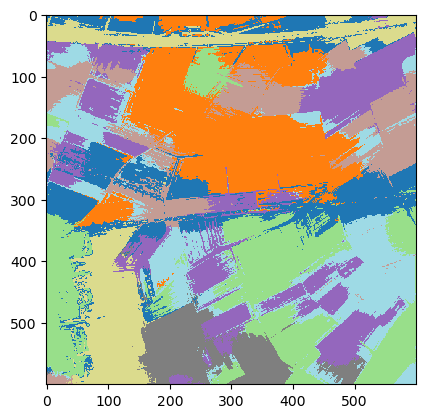

In [9]:
# import plotting; we'll use a discrete palette so clusters are clearly distinct
import matplotlib.pyplot as plt
# render the label grid with a categorical colormap and no smoothing between patches
plt.imshow(label_grid, cmap="tab20", interpolation="nearest")
# print a quick status so you know what you’re seeing (grid size and number of clusters)
print(f"visualizing clusters @ {label_grid.shape[0]}x{label_grid.shape[1]} with {label_grid.max()+1} clusters")
# display the figure
plt.show()


Low Res Clusters

In [21]:

import torch
from torchvision import transforms
import numpy as np

# ViT patch size and current image size (PIL Image `img` must be defined earlier)
ps = 16
W, H = img.size  # PIL returns (width, height)

# compute next multiples so patches tile cleanly
Wm = ((W + ps - 1) // ps) * ps
Hm = ((H + ps - 1) // ps) * ps
pad_w, pad_h = Wm - W, Hm - H

print(f"original: {W}x{H}  →  next multiples of {ps}: {Wm}x{Hm}  (add {pad_w} px width, {pad_h} px height)")

# padding: (left, top, right, bottom)
pad_to_multiple = transforms.Pad((0, 0, pad_w, pad_h), fill=0)
to_tensor = transforms.Compose([pad_to_multiple, transforms.ToTensor()])

# convert to tensor and inspect shape (C, H, W)
img_tensor = to_tensor(img)
print("tensor shape:", tuple(img_tensor.shape))

# normalize using DINOv3 processor stats
normalize = transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
img_norm = normalize(img_tensor)

# add batch dim and move to device
x = img_norm.unsqueeze(0).to(device)
print("ready tensor:", tuple(x.shape), " device:", x.device)

# build inverse normalization (to visualize / clamp back to [0,1])
inv = transforms.Normalize(
    mean=[-m / s for m, s in zip(processor.image_mean, processor.image_std)],
    std=[1.0 / s for s in processor.image_std],
)
img_vis = torch.clamp(inv(img_norm), 0.0, 1.0)  # tensor in [0,1]

# forward pass to get tokens (no grads)
with torch.no_grad():
    out = model(pixel_values=x)

# drop CLS and any register tokens, keep spatial patch tokens
R = getattr(model.config, "num_register_tokens", 0)
patch = out.last_hidden_state[:, 1 + R :, :]  # shape: (1, P, D)
print("patch shape (1,P,D):", tuple(patch.shape))

# compute patch grid dims from padded tensor size
ps, Hx, Wx = 16, x.shape[2], x.shape[3]
Hp, Wp = Hx // ps, Wx // ps

# reshape flat tokens (1,P,D) -> (1, Hp, Wp, D)
patch_grid = patch.reshape(1, Hp, Wp, patch.shape[-1])
print(f"HxW={Hx}x{Wx}  Hp×Wp={Hp}×{Wp}={Hp*Wp}  grid shape={tuple(patch_grid.shape)}")



original: 2190x1125  →  next multiples of 16: 2192x1136  (add 2 px width, 11 px height)
tensor shape: (3, 1136, 2192)
ready tensor: (1, 3, 1136, 2192)  device: cuda:0
patch shape (1,P,D): (1, 9727, 1024)
HxW=1136x2192  Hp×Wp=71×137=9727  grid shape=(1, 71, 137, 1024)


In [23]:
# we’ll cluster in feature space, so build a 2D matrix X = (num_patches × feature_dim)
import numpy as np

# L2-normalize each patch vector so distance ~ cosine distance (helps k-means separate textures like roads/roofs)
# prepare feature matrix X for clustering (num_patches × feature_dim) as numpy float32
X = patch.reshape(-1, patch.shape[-1]).detach().cpu().numpy().astype("float32")
X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)

# print sanity checks before clustering
print("X shape:", X.shape, " mean L2 norm:", float(np.linalg.norm(X, axis=1).mean()))


X shape: (9727, 1024)  mean L2 norm: 1.0


In [24]:
from sklearn.cluster import KMeans
# we’ll use MiniBatchKMeans to group similar patch embeddings (fast, memory-friendly) into k semantic clusters
from sklearn.cluster import MiniBatchKMeans

# choose an initial cluster count (k=8 is a reasonable start to separate roads/roofs/veg/shadows etc.)
kmeans = MiniBatchKMeans(n_clusters=8, random_state=12, batch_size=2048, max_iter=100)
# run clustering on the L2-normalized embeddings to obtain one label per patch (0..k-1)
labels = kmeans.fit_predict(X)

# report how many patches fell into each cluster so we can gauge balance before mapping to the image grid
print("labels shape:", labels.shape, " | counts per cluster:", np.bincount(labels, minlength=8))


labels shape: (9727,)  | counts per cluster: [ 965  985 1836  874 1797 1601  311 1358]


In [26]:
# derive patches per side from the original patch_grid shape (low-res)
Hp, Wp = patch_grid.shape[1], patch_grid.shape[2]  # from your earlier code

# reshape labels using the low-res patch grid dimensions
label_grid = labels.reshape(Hp, Wp)

# quick sanity: report grid shape and how many distinct clusters are present
print("label_grid:", label_grid.shape, " unique clusters:", np.unique(label_grid).size)


label_grid: (71, 137)  unique clusters: 8


visualizing clusters @ 71x137 with 8 clusters


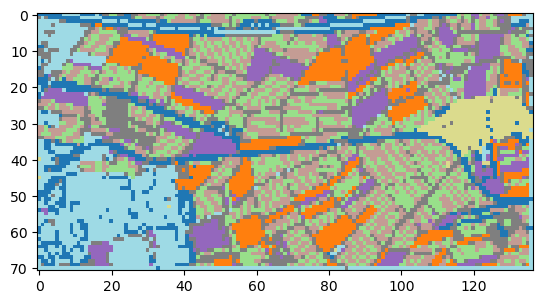

In [27]:
# import plotting; we'll use a discrete palette so clusters are clearly distinct
import matplotlib.pyplot as plt
# render the label grid with a categorical colormap and no smoothing between patches
plt.imshow(label_grid, cmap="tab20", interpolation="nearest")
# print a quick status so you know what you’re seeing (grid size and number of clusters)
print(f"visualizing clusters @ {label_grid.shape[0]}x{label_grid.shape[1]} with {label_grid.max()+1} clusters")
# display the figure
plt.show()
